# FBXL4
[Encephalomyopathic mitochondrial DNA depletion syndrome-13 (MTDPS13)](https://omim.org/entry/615471) is caused by homozygous mutation in the FBXL4 gene. Mitochondrial DNA depletion syndrome-13 is an autosomal recessive disorder characterized by early infantile onset of encephalopathy, hypotonia, lactic acidosis, and severe global developmental delay.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


# FBXL4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBXL4.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'FBXL4'
mane_tx_id = 'NM_001278716.2'
mane_protein_id = 'NP_001265645.1' # F-box/LRR-repeat protein 4
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 95/95 [00:01<00:00, 68.42 individuals/s] 
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
92,Increased circulating lactate concentration
79,Hypotonia
52,Global developmental delay
39,Global brain atrophy
36,Feeding difficulties
32,Failure to thrive
30,Cerebral atrophy
28,Small for gestational age
27,Short stature
27,Microcephaly


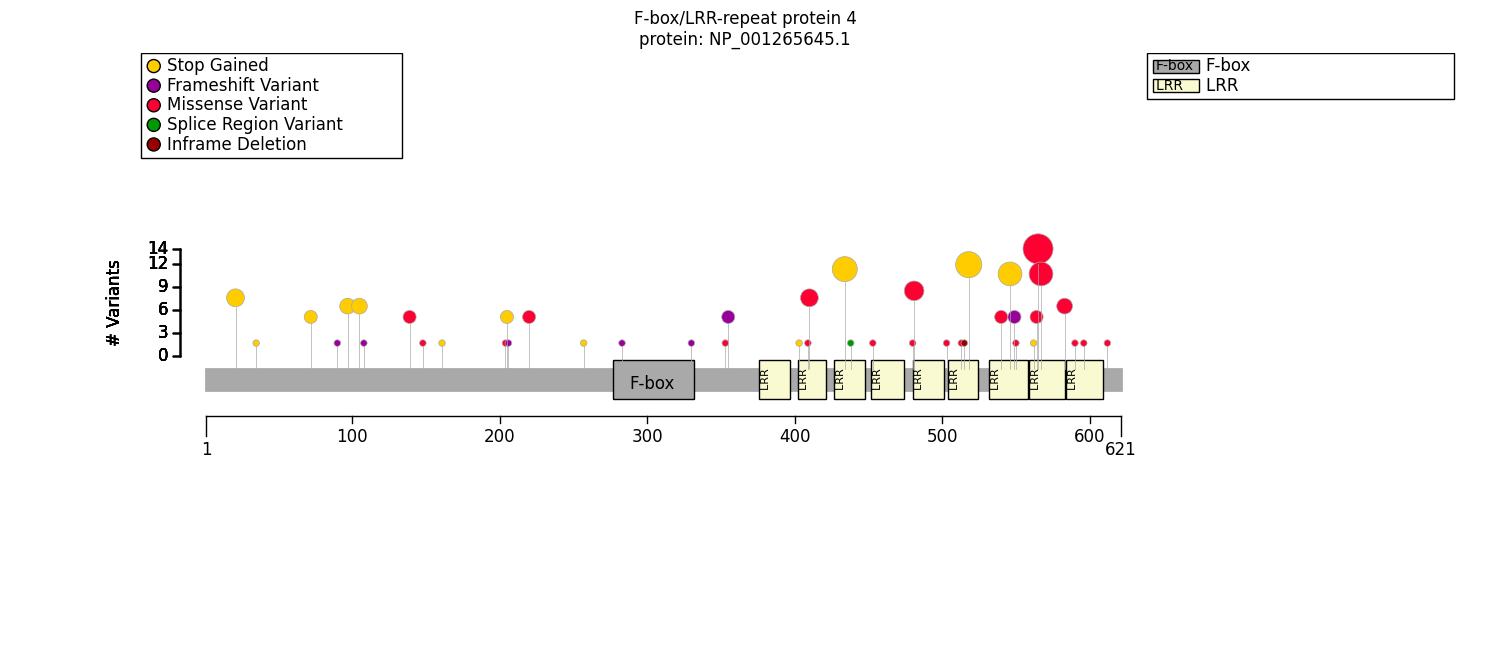

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

fbxl4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
fbxl4_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
14,6_98875419_98875419_T_C,c.1698A>G (p.Ile566Met),9,missense
10,6_98875562_98875562_G_A,c.1555C>T (p.Gln519Ter),9,stop gained
8,6_98874441_98874441_C_G,c.1703G>C (p.Gly568Ala),10,"missense, splice region"
8,6_98875474_98875476_TCA_T,c.1641_1642del (p.Cys547Ter),9,"stop gained, frameshift"
6,6_98899282_98899282_G_A,c.1303C>T (p.Arg435Ter),7,stop gained
5,6_98875673_98875673_G_A,c.1444C>T (p.Arg482Trp),9,missense
4,6_98899353_98899353_C_T,c.1232G>A (p.Cys411Tyr),7,missense
4,6_98926925_98926925_G_A,c.64C>T (p.Arg22Ter),4,stop gained
3,6_98874394_98874394_A_G,c.1750T>C (p.Cys584Arg),10,missense
3,6_98926697_98926697_G_A,c.292C>T (p.Arg98Ter),4,stop gained


In [7]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
2,F-box,Domain,278 - 332,p.Leu332ThrfsTer3; p.Pro284LeufsTer7
0,LRR 1,Repeat,377 - 397,
6,LRR 2,Repeat,403 - 421,p.Gln404Ter; p.Cys411Tyr; p.Ser410Phe
10,LRR 3,Repeat,428 - 448,p.Arg435Ter; p.Glu439=; p.Arg435Gln; p.Arg435Leu
1,LRR 4,Repeat,453 - 474,p.Gln454Pro
6,LRR 5,Repeat,481 - 501,p.Arg482Trp; p.Leu481Pro
12,LRR 6,Repeat,505 - 524,p.Pro516_Ser521del; p.Gln519Ter; p.Trp514Gly
13,LRR 7,Repeat,533 - 558,p.Ile551Asn; p.Cys547Ter; p.Asp550HisfsTer2; p.Thr541Ile
25,LRR 8,Repeat,560 - 583,p.Gly568Ala; p.Ile566Met; p.Gln563Ter; p.Asp565Gly
2,LRR 9,Repeat,585 - 609,p.Asp591Gly; p.Gln597Pro


# Genotype Phenotype Correlation (GPC) Analysis


In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import MtcStatsViewer

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_clf = biallelic_classifier(a_predicate=missense, 
                                  b_predicate=~missense,
                                  a_label="missense", 
                                  b_label="other",
                                  partitions=((1,2), (0,)))
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,4
"Skipping ""general"" level terms",87
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),203


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/other OR other/other,missense/missense,Corrected p values,p values
Feeding difficulties [HP:0011968],23/24 (96%),13/27 (48%),0.009539,0.000173
Optic atrophy [HP:0000648],8/26 (31%),0/26 (0%),0.076120,0.004152
Reduced visual acuity [HP:0007663],7/25 (28%),0/26 (0%),0.076120,0.004152
Long eyelashes [HP:0000527],8/32 (25%),1/34 (3%),0.162754,0.011837
Nystagmus [HP:0000639],10/32 (31%),2/27 (7%),0.268464,0.027666
Cryptorchidism [HP:0000028],7/16 (44%),4/30 (13%),0.268464,0.031903
Microcephaly [HP:0000252],20/34 (59%),7/24 (29%),0.268464,0.034168
Bilateral tonic-clonic seizure with generalized onset [HP:0025190],7/23 (30%),1/22 (5%),0.322967,0.046977
Short stature [HP:0004322],18/28 (64%),9/25 (36%),0.325602,0.055613
Failure to thrive [HP:0001508],21/30 (70%),11/25 (44%),0.325602,0.061266


In [11]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_feature, anyof

# LRR 1
lrr_domains = list() # LRR 1 to 9
for i in range(1,10):
    label = f"LRR {i}"
    is_lrr = protein_feature(feature_id=label, protein_metadata=protein_meta)
    lrr_domains.append(is_lrr)

lrr = anyof(lrr_domains)

lrr_clf = biallelic_classifier(a_predicate=lrr, 
                                    b_predicate=~lrr,
                                    a_label="LRR domain", 
                                    b_label="other",
                                  partitions=((0,1), (2,)))
lrr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=lrr_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=lrr_result)

Allele group,LRR domain/LRR domain OR LRR domain/other,other/other,Corrected p values,p values
Feeding difficulties [HP:0011968],24/39 (62%),12/12 (100%),0.305371,0.010509
Wide nasal bridge [HP:0000431],8/53 (15%),7/15 (47%),0.305371,0.015371
Nystagmus [HP:0000639],6/46 (13%),6/13 (46%),0.305371,0.016657
Thick eyebrow [HP:0000574],6/54 (11%),5/14 (36%),0.559359,0.040681
Cryptorchidism [HP:0000028],7/38 (18%),4/8 (50%),0.867967,0.078906
Periventricular cysts [HP:0007109],3/37 (8%),3/11 (27%),1.000000,0.123814
Infantile spasms [HP:0012469],0/37 (0%),1/8 (12%),1.000000,0.177778
Epicanthus [HP:0000286],7/53 (13%),4/14 (29%),1.000000,0.222695
Neutropenia [HP:0001875],9/57 (16%),4/13 (31%),1.000000,0.242892
Long philtrum [HP:0000343],8/54 (15%),4/14 (29%),1.000000,0.251095


In [12]:
# N-terminal, located N-terminal to the F-box domain: 277-332
from gpsea.analysis.predicate import protein_region

nterm = protein_region(region=Region(start=1, end=276), tx_id=mane_tx_id)
nterm_clf = biallelic_classifier(a_predicate=lrr, 
                                  b_predicate=~lrr,
                                  a_label="N-Terminal (1-276)", 
                                  b_label="other",
                                  partitions=((0,1), (2,)))
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N-Terminal (1-276)/N-Terminal (1-276) OR N-Terminal (1-276)/other,other/other,Corrected p values,p values
Feeding difficulties [HP:0011968],24/39 (62%),12/12 (100%),0.305371,0.010509
Wide nasal bridge [HP:0000431],8/53 (15%),7/15 (47%),0.305371,0.015371
Nystagmus [HP:0000639],6/46 (13%),6/13 (46%),0.305371,0.016657
Thick eyebrow [HP:0000574],6/54 (11%),5/14 (36%),0.559359,0.040681
Cryptorchidism [HP:0000028],7/38 (18%),4/8 (50%),0.867967,0.078906
Periventricular cysts [HP:0007109],3/37 (8%),3/11 (27%),1.000000,0.123814
Infantile spasms [HP:0012469],0/37 (0%),1/8 (12%),1.000000,0.177778
Epicanthus [HP:0000286],7/53 (13%),4/14 (29%),1.000000,0.222695
Neutropenia [HP:0001875],9/57 (16%),4/13 (31%),1.000000,0.242892
Long philtrum [HP:0000343],8/54 (15%),4/14 (29%),1.000000,0.251095


In [13]:
from gpsea.analysis.clf import sex_classifier

mf_result =  analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Long eyelashes [HP:0000527],7/27 (26%),2/39 (5%),0.809364,0.025969
Short stature [HP:0004322],14/20 (70%),13/33 (39%),0.809364,0.047270
Feeding difficulties [HP:0011968],18/21 (86%),18/30 (60%),0.809364,0.064168
Ptosis [HP:0000508],4/26 (15%),1/40 (2%),0.809364,0.074274
Reduced visual acuity [HP:0007663],5/19 (26%),2/32 (6%),0.809364,0.086823
Failure to thrive [HP:0001508],16/22 (73%),16/33 (48%),0.809364,0.097738
Ventriculomegaly [HP:0002119],9/19 (47%),8/34 (24%),0.809364,0.123855
Optic atrophy [HP:0000648],5/19 (26%),3/33 (9%),0.809364,0.124101
Hypotonia [HP:0001252],32/32 (100%),47/52 (90%),0.809364,0.151278
Microcephaly [HP:0000252],12/20 (60%),15/38 (39%),0.809364,0.171573


In [14]:
from gpsea.analysis.temporal.endpoint import death

from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=death() 
)
print(f"survival analysis p={missense_mortality_result.pval:.5f}");

survival analysis p=0.08031


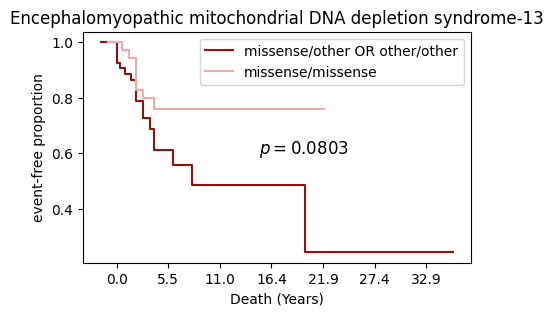

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_mortality_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Death (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Encephalomyopathic mitochondrial DNA depletion syndrome-13")
s = f"p={missense_mortality_result.pval:.4f}"
ax.text(x=5500, y=0.6, s=f"${s}$", fontsize=12);

In [16]:
from gpsea.analysis.temporal.endpoint import disease_onset

d_onset = disease_onset("OMIM:615471")
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=d_onset
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")

survival analysis p=0.03066


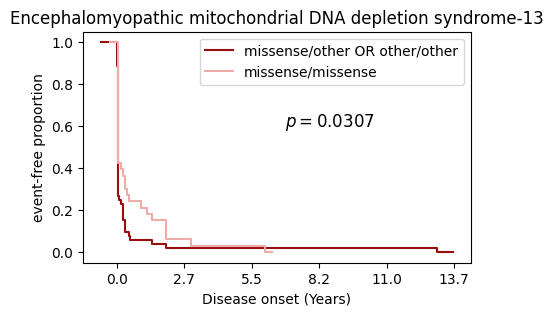

In [17]:
onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)

ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Disease onset (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Encephalomyopathic mitochondrial DNA depletion syndrome-13")
s = f"p={missense_onset_result.pval:.4f}"
ax.text(x=2500, y=0.6, s=f"${s}$", fontsize=12);

# Summary

In [18]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
     GPAnalysisResultSummary.from_mono(
        result=missense_mortality_result
    )
)

FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=lrr_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = """presence of missense variants is expected to be associated withpreservation of some residual protein function 
and therefore milder phenotype than that associated with biallelic null variants. 
El-Hattab  et al. (2017) showed a significant difference between individuals with biallelic missense variants 
and those compound heterozygous for missense and null variants"""

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [19]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [20]:
summarizer.process_latex(report=report, protein_fig=fbxl4_fig, stats_fig=onset_fig)

Figure saved to ../../supplement/img/FBXL4_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/FBXL4_stats-draft.pdf
Output to ../../supplement/tex/FBXL4_summary_draft.tex
